In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


training_data_easy = "../data/deduplicated_data/training_data_easy.csv"
training_data_hard = "../data/deduplicated_data/training_data_hard.csv"

# Features
FEATURES = [
    "sequence_length","gc_content","sequence_entropy","mfe","ens_def",
    "longest_sequential_A","longest_sequential_C","longest_sequential_U","longest_sequential_G",
    "longest_GC_helix","GU_pairs","rate_of_bps_predicted","hairpin_count","junction_count",
    "helix_count","singlestrand_count","mway_junction_count","AU_pairs_in_helix_terminal_ends",
    "helices_with_reverse_complement","hairpins_with_gt4_unpaired_nts"
]

# Load + label
easy_df = pd.read_csv(training_data_easy)
hard_df = pd.read_csv(training_data_hard)
easy_df["_label"] = 0  # 0 = easy
hard_df["_label"] = 1  # 1 = hard
df = pd.concat([easy_df, hard_df], ignore_index=True)

In [4]:
X = df[FEATURES].apply(pd.to_numeric, errors="coerce")
mask = X.notna().all(axis=1)
X = X.loc[mask]
y = df.loc[mask, "_label"]

density_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)
density_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [5]:
def density_hardness_score_nb(feature_dict: dict) -> float:
    """
    Returns P(hard) based on Gaussian Naive Bayes (a likelihood-based classifier).
    """
    row = pd.DataFrame([feature_dict], columns=FEATURES).apply(pd.to_numeric, errors="coerce")
    if row.isna().any(axis=1).iloc[0]:
        missing = row.columns[row.isna().iloc[0]].tolist()
        raise ValueError(f"Missing/non-numeric features: {missing}")

    # Predict posterior via Bayes rule using class-conditional likelihoods
    return float(density_model.predict_proba(row)[0, 1])

def density_log_likelihoods_nb(feature_dict: dict):
    """
    Returns (log p(x|easy)+const, log p(x|hard)+const) in the NB internal space.
    Useful if you want raw likelihood comparison.
    """
    row = pd.DataFrame([feature_dict], columns=FEATURES).apply(pd.to_numeric, errors="coerce")
    if row.isna().any(axis=1).iloc[0]:
        missing = row.columns[row.isna().iloc[0]].tolist()
        raise ValueError(f"Missing/non-numeric features: {missing}")

    scaler = density_model.named_steps["standardscaler"]
    nb = density_model.named_steps["gaussiannb"]

    z = scaler.transform(row)
    # these are joint log-likelihoods up to priors; good for comparisons
    jll = nb._joint_log_likelihood(z)[0]  # array([easy, hard])
    return float(jll[0]), float(jll[1])

In [6]:
from attr_predictor import AttrPredictor

# Easy
seq = "GGAAAGAGUAGCGAAAAGGUGUCGGAAGACACCAAAAGGAGACGGAAGUCUCCAAAACACUACUCAAAGACCACCUUCGGGUGGUCAAAAGAAACAACAACAACAAC"
stc = ".....((((((.(....((((((....))))))....((((((....))))))....).))))))...(((((((....)))))))....................."

features = AttrPredictor.pred_attrs(seq, stc)
density_hardness_score_nb(features)

2.389950733780158e-11

In [7]:
# Hard
seq = "GGGCUACCAAAGCUACGGAAACGUAGCAAAGUUCAAAGCUACGGAAACGUAGCAAAGCUACGGAAACGUAGCAAAGAACAAAGGUAGCAAAGGUUCGCUUCGGCGAACCAAAAGAAACAACAACAACAAC"
stc = "..((((((...((((((....))))))...((((...((((((....((((((...))))))....))))))...))))...))))))...(((((((....)))))))....................."

features = AttrPredictor.pred_attrs(seq, stc)
density_hardness_score_nb(features)

0.9998539246583064

In [9]:
def get_confidence_score(seq, stc):
    features = AttrPredictor.pred_attrs(seq, stc)
    return density_hardness_score_nb(features)

.....((((((......((((((....))))))....((((((....))))))......))))))...((((((((..))))))))..................... has a hairpin that is too small
........((((((((...((((((....))))))...((((((....))))))...))))))))...((((((((..))))))))..................... has a hairpin that is too small
.....((((((.......((((((....))))))....(((((....))))).......))))))...((((((((..))))))))..................... has a hairpin that is too small
.....((((((.......((((((....))))))....(((((....))))).......))))))...((((((((..))))))))..................... has a hairpin that is too small
.....((((((.......((((((....))))))....(((((....))))).......))))))...((((((((..))))))))..................... has a hairpin that is too small
........((((((((...(((((....())))))...((((((....))))))...)))))))).....(((((..())))))(.....................) has a hairpin that is too small
........((((((((...((((((....))))))...(((((((..)))))))...))))))))...((((((((..))))))))..................... has a hairpin that is too small
.....((((((.......((

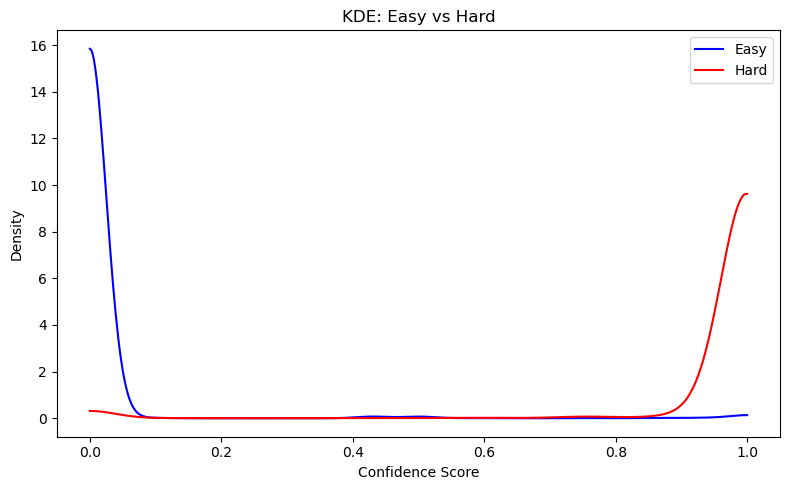

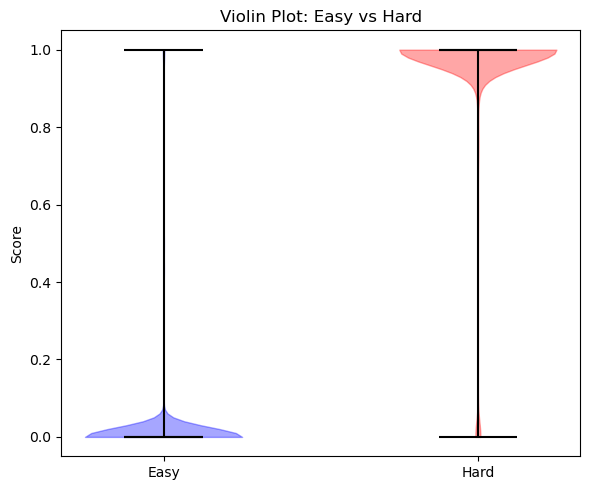

Found 1956/2002 true positives (97.70%)
Found 1847/2002 true negatives (97.70%)
Found 123 did not meet either cutoff (3.07%)


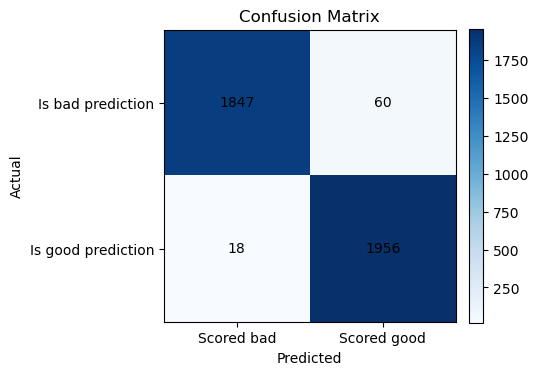

In [14]:
easy_scores = []
hard_scores = []

with open("../data/deduplicated_data/easy_testing.csv") as fh:
    data = [line.split(",") for line in fh.readlines()]
    data.pop(0)
    for d in data:
        seq = d[2]
        stc = d[4]
        easy_scores.append(
            get_confidence_score(seq, stc)
        )

with open("../data/deduplicated_data/hard_testing.csv") as fh:
    data = [line.split(",") for line in fh.readlines()]
    data.pop(0)
    for d in data:
        seq = d[2]
        stc = d[4]
        hard_scores.append(
            get_confidence_score(seq, stc)
        )

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# easy_scores: list[float]
# hard_scores: list[float]

easy = np.asarray(easy_scores, dtype=float)
hard = np.asarray(hard_scores, dtype=float)

# Drop NaNs / infs if present
easy = easy[np.isfinite(easy)]
hard = hard[np.isfinite(hard)]

# Shared x-range for fair comparison
xmin = float(min(easy.min(), hard.min()))
xmax = float(max(easy.max(), hard.max()))
xs = np.linspace(xmin, xmax, 512)

# KDEs (Scott's rule by default)
kde_easy = gaussian_kde(easy)
kde_hard = gaussian_kde(hard)

plt.figure(figsize=(8, 5))
plt.plot(xs, kde_easy(xs), color="blue", label="Easy")
plt.plot(xs, kde_hard(xs), color="red", label="Hard")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.title("KDE: Easy vs Hard")
plt.legend()
plt.tight_layout()
plt.show()


easy = np.asarray(easy_scores, dtype=float)
hard = np.asarray(hard_scores, dtype=float)

# Drop NaNs / infs if present
easy = easy[np.isfinite(easy)]
hard = hard[np.isfinite(hard)]

if easy.size == 0 or hard.size == 0:
    raise ValueError("Both lists must contain at least one finite value.")

plt.figure(figsize=(6, 5))
parts = plt.violinplot([easy, hard], showmeans=False, showmedians=True, showextrema=True)

# Color the bodies
parts["bodies"][0].set_facecolor("blue")
parts["bodies"][0].set_edgecolor("blue")
parts["bodies"][0].set_alpha(0.35)

parts["bodies"][1].set_facecolor("red")
parts["bodies"][1].set_edgecolor("red")
parts["bodies"][1].set_alpha(0.35)

# Optionally color the lines (medians/extrema) to match
for k in ("cmedians", "cmins", "cmaxes", "cbars"):
    if k in parts:
        parts[k].set_color("black")

plt.xticks([1, 2], ["Easy", "Hard"])
plt.ylabel("Score")
plt.title("Violin Plot: Easy vs Hard")
plt.tight_layout()
plt.show()

cutoffs = {
    "easy": 0.05,
    "hard": 0.95
}

# a "positive" is identifying a good prediction as "probably good"
# a "negative" is identifying a bad prediction as "probably bad"
tp = 0
fp = 0
tn = 0
fn = 0
uncategorized = 0

for score in easy_scores:
    # True positive
    if score <= cutoffs["easy"]:
        tp += 1
    elif score >= cutoffs["hard"]:
        fn += 1
    else:
        uncategorized += 1

for score in hard_scores:
    # True negative
    if score >= cutoffs["hard"]:
        tn += 1
    elif score <= cutoffs["easy"]:
        fp += 1
    else:
        uncategorized += 1


print(f"Found {tp}/{len(easy_scores)} true positives ({(tp / len(easy_scores)) * 100:.2f}%)")
print(f"Found {tn}/{len(hard_scores)} true negatives ({(tp / len(hard_scores)) * 100:.2f}%)")
print(f"Found {uncategorized} did not meet either cutoff ({uncategorized / (len(hard_scores) + len(easy_scores)) * 100:.2f}%)")


import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(tn: int, fp: int, fn: int, tp: int, *, title="Confusion Matrix"):
    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")

    # Axis labels
    ax.set_xticks([0, 1], labels=["Scored bad", "Scored good"])
    ax.set_yticks([0, 1], labels=["Is bad prediction", "Is good prediction"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    # Annotate cells
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v}", ha="center", va="center")

    # Colorbar
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# usage:
plot_confusion_matrix(tn, fp, fn, tp)



(.......(..(((((((...((((((...((((((....))))))...))))))...))))))))..(((((((..())))))))....................) has a hairpin that is too small
..........((((((((...((((((.(.((((((....)))))).).))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((...((((((.(.((((((....)))))).).))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((...((((((...((((((....))))))...))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((...((((((...((((((....))))))...))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((...((((((...((((((....))))))...))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((...((((((...(((((((..)))))))...))))))...))))))))..((((((((..))))))))..................... has a hairpin that is too small
..........((((((((..

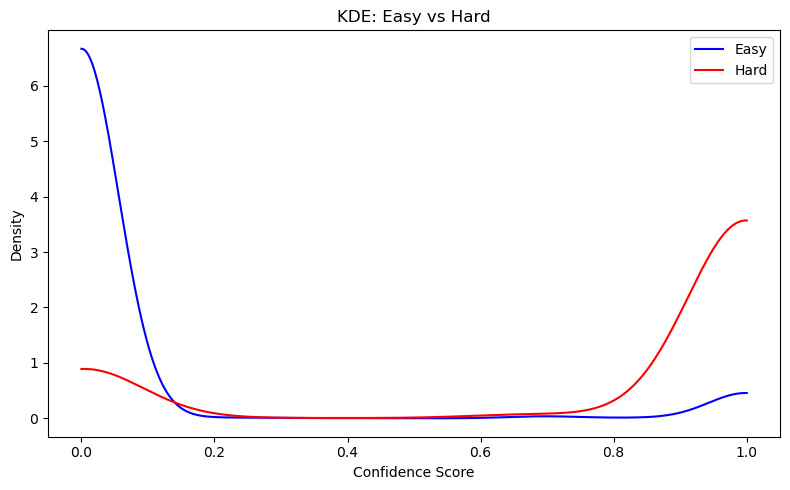

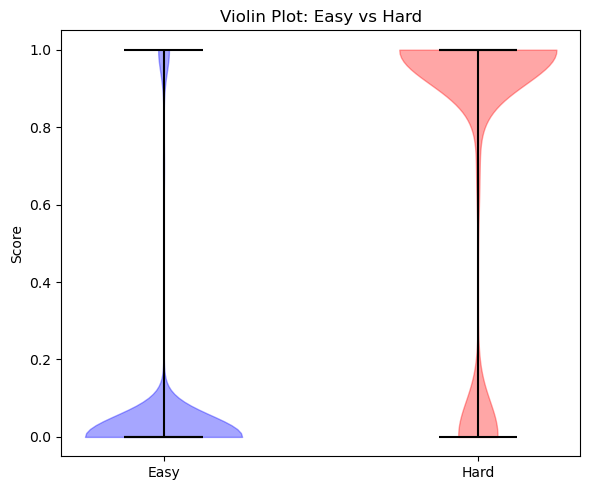

Found 1755/1898 true positives (92.47%)
Found 1532/2002 true negatives (87.66%)
Found 120 did not meet either cutoff (3.08%)


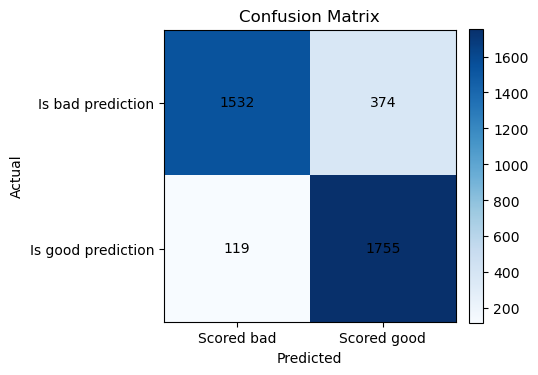

In [15]:
# Try with validation data as well
easy_scores = []
hard_scores = []

with open("../data/deduplicated_data/easy_validation.csv") as fh:
    data = [line.split(",") for line in fh.readlines()]
    data.pop(0)
    for d in data:
        seq = d[2]
        stc = d[4]
        easy_scores.append(
            get_confidence_score(seq, stc)
        )

with open("../data/deduplicated_data/hard_validation.csv") as fh:
    data = [line.split(",") for line in fh.readlines()]
    data.pop(0)
    for d in data:
        seq = d[2]
        stc = d[4]
        hard_scores.append(
            get_confidence_score(seq, stc)
        )

easy = np.asarray(easy_scores, dtype=float)
hard = np.asarray(hard_scores, dtype=float)

# Drop NaNs / infs if present
easy = easy[np.isfinite(easy)]
hard = hard[np.isfinite(hard)]

# Shared x-range for fair comparison
xmin = float(min(easy.min(), hard.min()))
xmax = float(max(easy.max(), hard.max()))
xs = np.linspace(xmin, xmax, 512)

# KDEs (Scott's rule by default)
kde_easy = gaussian_kde(easy)
kde_hard = gaussian_kde(hard)

plt.figure(figsize=(8, 5))
plt.plot(xs, kde_easy(xs), color="blue", label="Easy")
plt.plot(xs, kde_hard(xs), color="red", label="Hard")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.title("KDE: Easy vs Hard")
plt.legend()
plt.tight_layout()
plt.show()

easy = np.asarray(easy_scores, dtype=float)
hard = np.asarray(hard_scores, dtype=float)

# Drop NaNs / infs if present
easy = easy[np.isfinite(easy)]
hard = hard[np.isfinite(hard)]

if easy.size == 0 or hard.size == 0:
    raise ValueError("Both lists must contain at least one finite value.")

plt.figure(figsize=(6, 5))
parts = plt.violinplot([easy, hard], showmeans=False, showmedians=True, showextrema=True)

# Color the bodies
parts["bodies"][0].set_facecolor("blue")
parts["bodies"][0].set_edgecolor("blue")
parts["bodies"][0].set_alpha(0.35)

parts["bodies"][1].set_facecolor("red")
parts["bodies"][1].set_edgecolor("red")
parts["bodies"][1].set_alpha(0.35)

# Optionally color the lines (medians/extrema) to match
for k in ("cmedians", "cmins", "cmaxes", "cbars"):
    if k in parts:
        parts[k].set_color("black")

plt.xticks([1, 2], ["Easy", "Hard"])
plt.ylabel("Score")
plt.title("Violin Plot: Easy vs Hard")
plt.tight_layout()
plt.show()

cutoffs = {
    "easy": 0.05,
    "hard": 0.95
}

# a "positive" is identifying a good prediction as "probably good"
# a "negative" is identifying a bad prediction as "probably bad"
tp = 0
fp = 0
tn = 0
fn = 0
uncategorized = 0

for score in easy_scores:
    # True positive
    if score <= cutoffs["easy"]:
        tp += 1
    elif score >= cutoffs["hard"]:
        fn += 1
    else:
        uncategorized += 1

for score in hard_scores:
    # True negative
    if score >= cutoffs["hard"]:
        tn += 1
    elif score <= cutoffs["easy"]:
        fp += 1
    else:
        uncategorized += 1


print(f"Found {tp}/{len(easy_scores)} true positives ({(tp / len(easy_scores)) * 100:.2f}%)")
print(f"Found {tn}/{len(hard_scores)} true negatives ({(tp / len(hard_scores)) * 100:.2f}%)")
print(f"Found {uncategorized} did not meet either cutoff ({uncategorized / (len(hard_scores) + len(easy_scores)) * 100:.2f}%)")

plot_confusion_matrix(tn, fp, fn, tp)


In [12]:
# From RNAFold Server:
get_confidence_score(
    "GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA",
    "(((((((..((((.........)))).(((((.......))))).....(((((.......))))))))))))."
)

1.0

In [13]:
# Made up
get_confidence_score(
    "CCCCAAAAUUUUGGGG",
    "((((........))))"
)

1.0